<h3>K-Means in Practice</p>

In [1]:
# Load important packages.
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import geopandas as gpd
from geopandas import GeoDataFrame, points_from_xy
from shapely.geometry import Point
import folium
sns.set_style('darkgrid')
os.environ["OMP_NUM_THREADS"] = '1'

Read the data set

In [2]:
df = pd.read_csv('sources/coordinates2.csv', encoding='ISO-8859-1')

In [3]:
df.shape

(452, 6)

In [4]:
df.head()

,CACODE,Address,Island,Latitude,Longitude,Population weighting
0,B11,"123 Blue Pool Road, Happy Valley, Hong Kong",Hong Kong,22.263618,114.190520,11077
1,B10,"6/F, Wong Nai Chung Municipal Services Buildin...",Hong Kong,22.268985,114.185783,15464
2,B09,"133 Wong Nai Chung Road, Happy Valley, Hong Kong",Hong Kong,22.275309,114.183275,19279
3,B08,"17 Tai Hang Drive, Causeway Bay, Hong Kong",Hong Kong,22.274712,114.193593,19202
4,B07,"Moreton Terrace, Causeway Bay, Hong Kong",Hong Kong,22.279504,114.189061,18548


In [5]:
df.isnull().sum()

CACODE                  0
Address                 0
Island                  0
Latitude                0
Longitude               0
Population weighting    0
dtype: int64

In [6]:
df.dtypes

CACODE                   object
Address                  object
Island                   object
Latitude                float64
Longitude               float64
Population weighting      int64
dtype: object

In [7]:
df['Island'].unique()

array(['Hong Kong', 'New Territories', 'Park Island', 'Kowloon',
       'Cheung Chau', 'Lamma Island', 'Lantau Island', 'Peng Chau'],
      dtype=object)

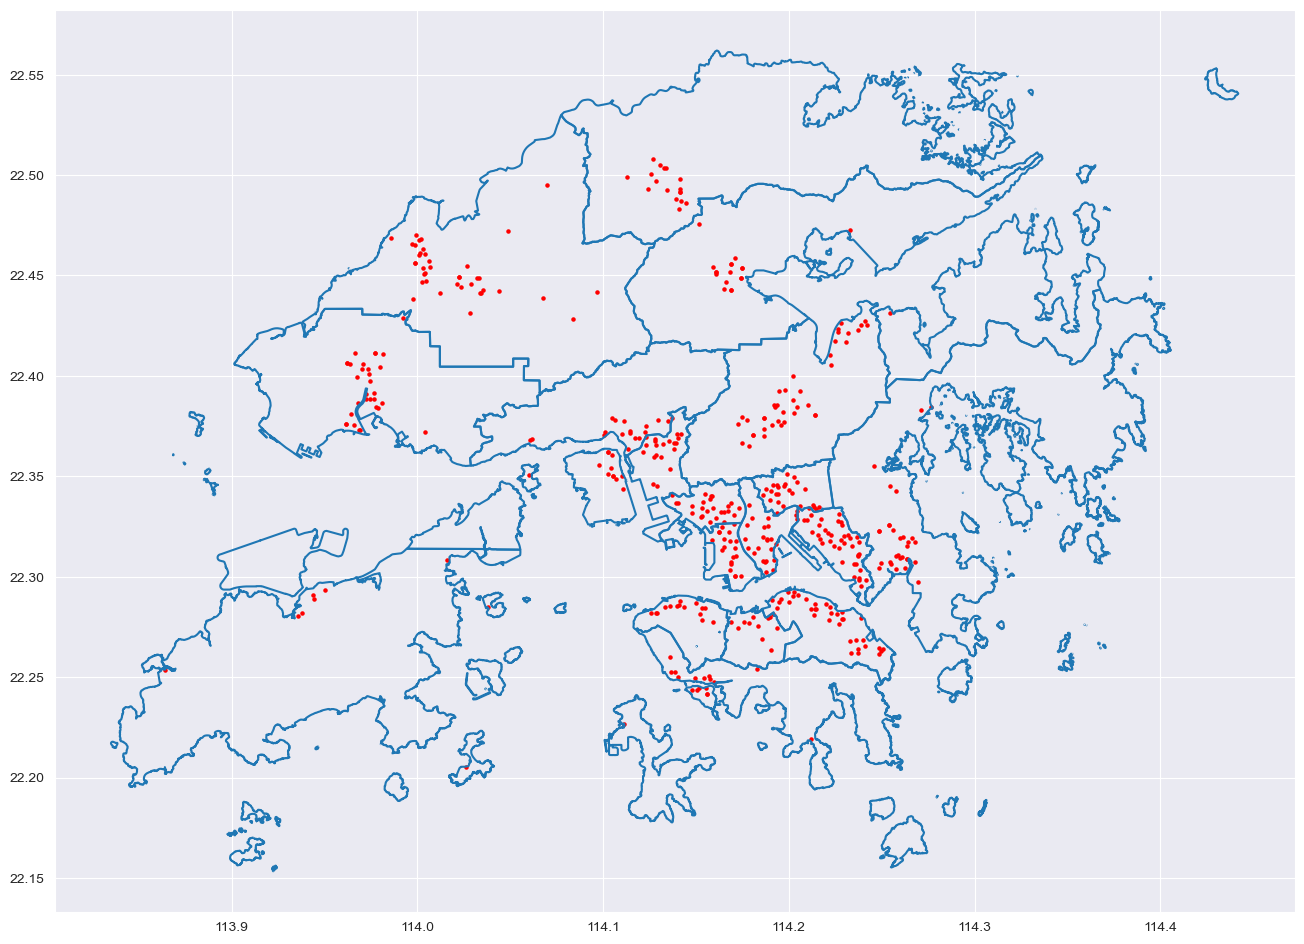

In [8]:
# Load the Hong Kong map data
hong_kong = GeoDataFrame.from_file('sources/Hong_Kong_18_Districts.geojson')

# adjust the map geometry to longitude and latitude format
hong_kong = hong_kong.to_crs(epsg=4326)

# Plot the map with the data points
fig, ax = plt.subplots(figsize=(16,12))
hong_kong.boundary.plot(ax=ax)
plt.scatter(df['Longitude'], df['Latitude'], c='r', s=5)
plt.show()

In [9]:
hong_kong.head()

,OBJECTID,ID,CNAME,CNAME_S,ENAME,geometry
0,1,1,黃大仙區,黄大仙区,WONG TAI SIN,"POLYGON ((114.17942 22.34905, 114.17946 22.349..."
1,2,6,九龍城區,九龙城区,KOWLOON CITY,"MULTIPOLYGON (((114.17700 22.34904, 114.17702 ..."
2,3,7,觀塘區,观塘区,KWUN TONG,"POLYGON ((114.24371 22.28620, 114.24370 22.286..."
3,4,8,西貢區,西贡区,SAI KUNG,"MULTIPOLYGON (((114.22112 22.35318, 114.22114 ..."
4,5,11,北區,北区,NORTH,"MULTIPOLYGON (((114.33576 22.51003, 114.33576 ..."


In [10]:
X = df[['Latitude', 'Longitude']]

In [11]:
df['Island'].unique()

array(['Hong Kong', 'New Territories', 'Park Island', 'Kowloon',
       'Cheung Chau', 'Lamma Island', 'Lantau Island', 'Peng Chau'],
      dtype=object)

In [12]:
# number of samples in each district
df['Island'].value_counts()

Island
New Territories    226
Kowloon            135
Hong Kong           80
Lantau Island        7
Park Island          1
Cheung Chau          1
Lamma Island         1
Peng Chau            1
Name: count, dtype: int64

In [13]:
X_Hong_Kong = df[df['Island'] == 'Hong Kong'][['Latitude', 'Longitude']]
X_Kowloon = df[df['Island'] == 'Kowloon'][['Latitude', 'Longitude']]
X_New_Territories = df[df['Island'] == 'New Territories'][['Latitude', 'Longitude']]

X_Hong_Kong.shape, X_Kowloon.shape, X_New_Territories.shape

((80, 2), (135, 2), (226, 2))

c:\Users\visha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\visha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\visha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\visha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

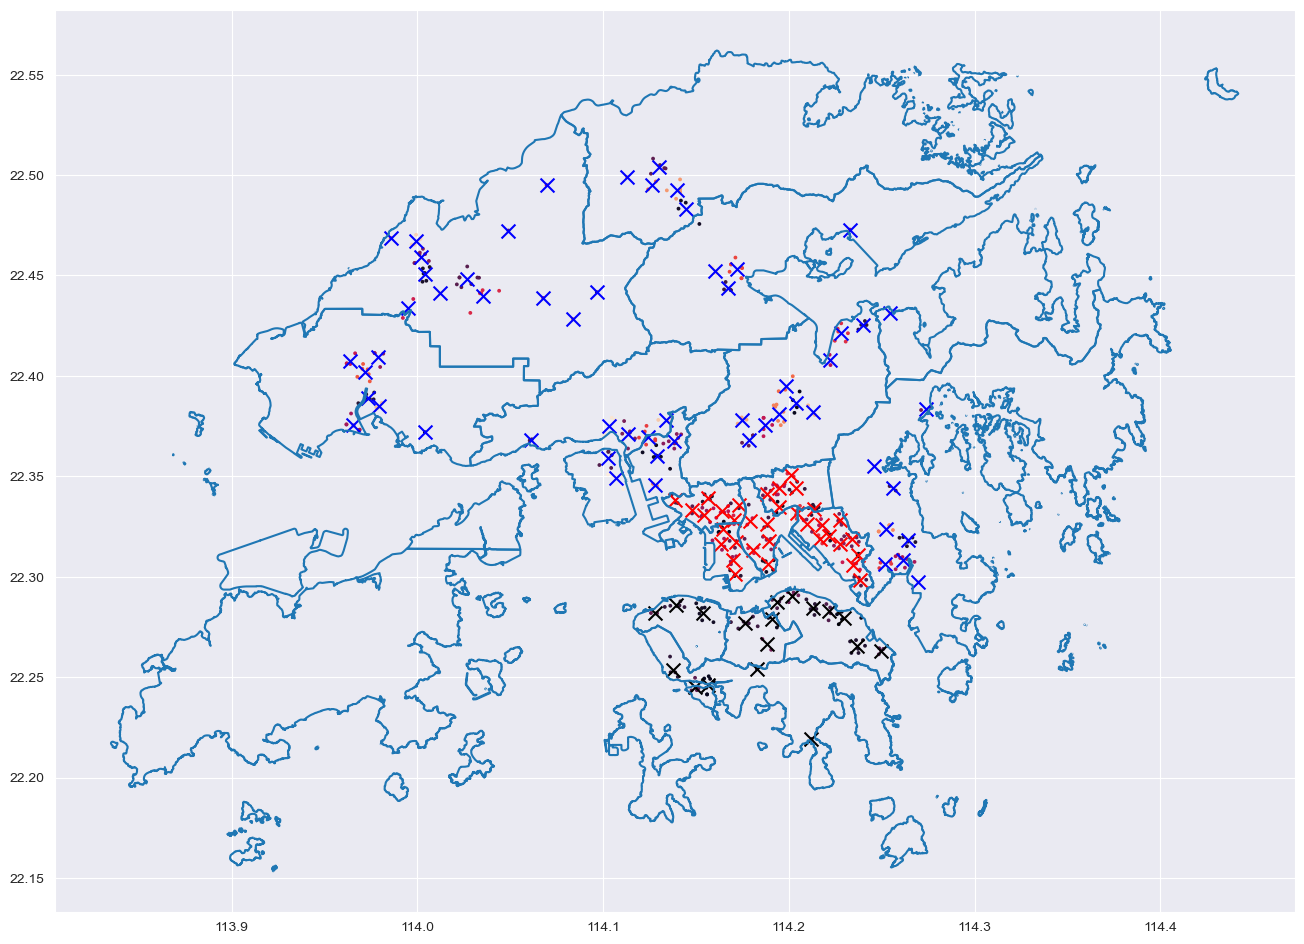

In [14]:
# Perform k-means clustering for each Island
def kmeans_clustering(X, k, island):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    df.loc[df['Island'] == island, 'Cluster'] = kmeans.labels_
    X['Cluster'] = kmeans.labels_
    return kmeans.cluster_centers_  # return the centroids

k_Hong_Kong = 18
k_Kowloon = 34
k_New_Territories = 58

centroids_Hong_Kong = kmeans_clustering(X_Hong_Kong, k_Hong_Kong, 'Hong Kong')
centroids_Kowloon = kmeans_clustering(X_Kowloon, k_Kowloon, 'Kowloon')
centroids_New_Territories = kmeans_clustering(X_New_Territories, k_New_Territories, 'New Territories')

# Plot the map with the data points
fig, ax = plt.subplots(figsize=(16,12))
hong_kong.boundary.plot(ax=ax)
plt.scatter(df['Longitude'], df['Latitude'], c=df['Cluster'], s=3)

# Plot the centroids
plt.scatter(centroids_Hong_Kong[:, 1], centroids_Hong_Kong[:, 0], color='black', marker='x', s=100)
plt.scatter( centroids_Kowloon[:, 1], centroids_Kowloon[:, 0], color='red', marker='x', s=100)
plt.scatter(centroids_New_Territories[:, 1], centroids_New_Territories[:, 0], color='blue', marker='x', s=100)

plt.show()

In [15]:
df.head()

,CACODE,Address,Island,Latitude,Longitude,Population weighting,Cluster
0,B11,"123 Blue Pool Road, Happy Valley, Hong Kong",Hong Kong,22.263618,114.190520,11077,17.0
1,B10,"6/F, Wong Nai Chung Municipal Services Buildin...",Hong Kong,22.268985,114.185783,15464,17.0
2,B09,"133 Wong Nai Chung Road, Happy Valley, Hong Kong",Hong Kong,22.275309,114.183275,19279,9.0
3,B08,"17 Tai Hang Drive, Causeway Bay, Hong Kong",Hong Kong,22.274712,114.193593,19202,2.0
4,B07,"Moreton Terrace, Causeway Bay, Hong Kong",Hong Kong,22.279504,114.189061,18548,2.0


In [16]:
df['Cluster'].value_counts()

Cluster
5.0     18
1.0     16
24.0    16
6.0     16
3.0     16
12.0    14
13.0    14
7.0     14
2.0     13
9.0     13
19.0    13
14.0    13
16.0    12
20.0    12
8.0     11
15.0    11
23.0    10
4.0     10
0.0     10
18.0     9
21.0     9
11.0     9
32.0     9
35.0     8
17.0     8
33.0     8
28.0     8
31.0     7
34.0     7
42.0     7
27.0     7
26.0     7
45.0     6
10.0     6
37.0     6
57.0     6
53.0     5
25.0     5
29.0     5
43.0     5
22.0     5
55.0     4
56.0     4
39.0     3
30.0     3
49.0     3
47.0     3
52.0     3
50.0     3
38.0     2
41.0     2
48.0     1
44.0     1
40.0     1
51.0     1
36.0     1
46.0     1
54.0     1
Name: count, dtype: int64

In [17]:
X_Hong_Kong

,Latitude,Longitude,Cluster
0,22.263618,114.190520,17
1,22.268985,114.185783,17
2,22.275309,114.183275,9
3,22.274712,114.193593,2
4,22.279504,114.189061,2
...,...,...,...
292,22.247781,114.159688,1
293,22.253969,114.182857,10
294,22.219180,114.212205,4
295,22.260234,114.136086,7


In [18]:
# interactive map with data points and clusters using folium library for Hong Kong Island
hong_kong_map = folium.Map(location=[22.265941, 114.180671], zoom_start=13)

# Define the colors for the 28 clusters
colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF', '#FFA500', '#A52A2A', '#800080',
          '#008000', '#000080', '#808000', '#800000', '#008080', '#808080', '#FF6347', '#FFD700', '#FF4500',
          '#FF69B4', '#FF1493', '#FF00FF', '#FF69B4', '#FF1493', '#FF00FF', '#FF69B4', '#FF1493', '#FF00FF',
          '#FF69B4']

# Add data points to the map
for i in range(len(X_Hong_Kong)):
    folium.CircleMarker(
        location=[X_Hong_Kong.iloc[i]['Latitude'], X_Hong_Kong.iloc[i]['Longitude']],
        radius=5,
        color=colors[int(X_Hong_Kong.iloc[i]['Cluster'])],
        fill=True,
        fill_color=colors[int(X_Hong_Kong.iloc[i]['Cluster'])]
    ).add_to(hong_kong_map)

# Add centroids to the map
for i in range(len(centroids_Hong_Kong)):
    folium.Marker(
        location=[centroids_Hong_Kong[i, 0], centroids_Hong_Kong[i, 1]],
        icon=folium.Icon(color=colors[i], icon='info-sign')
    ).add_to(hong_kong_map)

hong_kong_map

C:\Users\visha\AppData\Local\Temp\ipykernel_13360\89967827.py:24: UserWarning: color argument of Icon should be one of: {'darkgreen', 'lightgreen', 'blue', 'black', 'red', 'orange', 'pink', 'purple', 'darkred', 'cadetblue', 'darkblue', 'lightblue', 'lightgray', 'darkpurple', 'green', 'white', 'beige', 'lightred', 'gray'}.
  icon=folium.Icon(color=colors[i], icon='info-sign')


In [19]:
# interactive map with data points and clusters using folium library for Kowloon
kowloon_map = folium.Map(location=[22.3167, 114.1833], zoom_start=13)

# Define the colors for the 53 clusters
from random import randint
colors = []
for i in range(53):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

for i in range(len(X_Kowloon)):
    folium.CircleMarker(
        location=[X_Kowloon.iloc[i]['Latitude'], X_Kowloon.iloc[i]['Longitude']],
        radius=5,
        color=colors[int(X_Kowloon.iloc[i]['Cluster'])],
        fill=True,
        fill_color=colors[int(X_Kowloon.iloc[i]['Cluster'])]
    ).add_to(kowloon_map)

for i in range(len(centroids_Kowloon)):
    folium.Marker(
        location=[centroids_Kowloon[i, 0], centroids_Kowloon[i, 1]],
        icon=folium.Icon(color=colors[i], icon='info-sign')
    ).add_to(kowloon_map)

kowloon_map

C:\Users\visha\AppData\Local\Temp\ipykernel_13360\346498302.py:22: UserWarning: color argument of Icon should be one of: {'darkgreen', 'lightgreen', 'blue', 'black', 'red', 'orange', 'pink', 'purple', 'darkred', 'cadetblue', 'darkblue', 'lightblue', 'lightgray', 'darkpurple', 'green', 'white', 'beige', 'lightred', 'gray'}.
  icon=folium.Icon(color=colors[i], icon='info-sign')


In [20]:
# interactive map with data points and clusters using folium library for New Territories
new_territories_map = folium.Map(location=[22.3964, 114.1095], zoom_start=10)

# Define the colors for the 90 clusters
colors = []
for i in range(90):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

for i in range(len(X_New_Territories)):
    folium.CircleMarker(
        location=[X_New_Territories.iloc[i]['Latitude'], X_New_Territories.iloc[i]['Longitude']],
        radius=5,
        color=colors[int(X_New_Territories.iloc[i]['Cluster'])],
        fill=True,
        fill_color=colors[int(X_New_Territories.iloc[i]['Cluster'])]
    ).add_to(new_territories_map)

for i in range(len(centroids_New_Territories)):
    folium.Marker(
        location=[centroids_New_Territories[i, 0], centroids_New_Territories[i, 1]],
        icon=folium.Icon(color=colors[i], icon='info-sign')
    ).add_to(new_territories_map)

new_territories_map

C:\Users\visha\AppData\Local\Temp\ipykernel_13360\2791535057.py:21: UserWarning: color argument of Icon should be one of: {'darkgreen', 'lightgreen', 'blue', 'black', 'red', 'orange', 'pink', 'purple', 'darkred', 'cadetblue', 'darkblue', 'lightblue', 'lightgray', 'darkpurple', 'green', 'white', 'beige', 'lightred', 'gray'}.
  icon=folium.Icon(color=colors[i], icon='info-sign')


In [21]:
# centroids of each cluster
centroids_Hong_Kong, centroids_Kowloon, centroids_New_Territories

# Create a DataFrame with the centroids
centroids_df = pd.DataFrame(np.concatenate([centroids_Hong_Kong, centroids_Kowloon, centroids_New_Territories]),
                            columns=['Latitude', 'Longitude'])

# Add the Island column to the DataFrame
centroids_df['Island'] = ['Hong Kong'] * k_Hong_Kong + ['Kowloon'] * k_Kowloon + ['New Territories'] * k_New_Territories


centroids_df

,Latitude,Longitude,Island
0,22.279557,114.229683,Hong Kong
1,22.246311,114.156634,Hong Kong
2,22.278894,114.190935,Hong Kong
3,22.282172,114.153826,Hong Kong
4,22.219180,114.212205,Hong Kong
...,...,...,...
105,22.467411,113.999545,New Territories
106,22.355211,114.245936,New Territories
107,22.452196,114.160483,New Territories
108,22.374926,114.103147,New Territories


In [22]:
# Export the centroids to a CSV file
centroids_df.to_csv('sources/centroids_by_population_VR.csv', index=False)